Autoencoders
======

In [1]:
# # install pytorch (http://pytorch.org/) if run from Google Colaboratory
! pip install torchvision
import sys
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

  Using cached torchvision-0.21.0-cp39-cp39-macosx_11_0_arm64.whl (1.8 MB)
  Using cached torch-2.6.0-cp39-none-macosx_11_0_arm64.whl (66.5 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.5.1
    Uninstalling torch-2.5.1:
      Successfully uninstalled torch-2.5.1
You should consider upgrading via the '/Users/yuwang/recsys/bin/python3 -m pip install --upgrade pip' command.


Parameter Settings
-------------------

In [2]:
latent_dims = 10
num_epochs = 50
batch_size = 128
capacity = 64
learning_rate = 1e-3
use_gpu = True

MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. We normalize and center them around 0, which gives a slight performance boost during training.
We create both a training set and a test set.

In [3]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor(),  # converts to [0, 1]
    transforms.Normalize((0.5,), (0.5,)) # normalize tensor with mean=0.5 and std=0.5. x = (x-0.5)/0.5
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:01<00:00, 9.72MB/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 316kB/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 3.03MB/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 1.12MB/s]


Build Autoencoder
--------
An autoencoder consists of one encoder and one decoder. The encoder encodes the input data into a low-dimensional code/feature vector and the decoder reconstructs the input data from the low-dimensional code.

In [4]:
class MLP_AE(nn.Module):
  def __init__(self,architecture=[784,128,64,2],activation='LeakyReLU'):
        super(MLP_AE, self).__init__()
        self.architecture=architecture
        if activation=='LeakyReLU':
            self.activation=nn.LeakyReLU()
        elif activation=='ReLU':
            self.activation=nn.ReLU()
        elif activation=='Sigmoid':
            self.activation=nn.Sigmoid()
        else:
            print('Activation not defined, reverting to default!')
            self.activation=nn.LeakyReLU()
        # Defining $\phi$
        arch=[]
        for i in range(1,len(architecture)):
            arch.append(nn.Linear(architecture[i-1],architecture[i]))
            if i!=len(architecture)-1:
                arch.append(self.activation)
        self.encoder=nn.Sequential(*arch)
        # Defining $\psi$
        arch=[]
        for i in range(len(architecture)-1,0,-1):
            arch.append(nn.Linear(architecture[i],architecture[i-1]))
            if i!=1:
                arch.append(self.activation)
        self.decoder=nn.Sequential(*arch)

  def encode(self,f):
        assert f.shape[1]==self.architecture[0]
        return self.encoder(f)

  def decode(self,fhat):
        assert fhat.shape[1]==self.architecture[-1]
        return self.decoder(fhat)

  def forward(self,x):
    return self.decode(self.encode(x))
    
autoencoder = MLP_AE()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
autoencoder = autoencoder.to(device)

num_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 218514


Train Autoencoder
--------

In [5]:
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
autoencoder.train()

train_loss_avg = []

# MSE loss is used to compute the reconstruction error.
criterion=nn.MSELoss()

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        # flatten image into 1-D vector
        image_batch = image_batch.to(device).reshape(image_batch.shape[0],-1)
        
        # autoencoder reconstruction
        image_batch_recon = autoencoder(image_batch)
        
        # reconstruction error
        loss = criterion(image_batch_recon, image_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 50] average reconstruction error: 0.243305
Epoch [2 / 50] average reconstruction error: 0.192414
Epoch [3 / 50] average reconstruction error: 0.179662
Epoch [4 / 50] average reconstruction error: 0.173982
Epoch [5 / 50] average reconstruction error: 0.170547
Epoch [6 / 50] average reconstruction error: 0.168231
Epoch [7 / 50] average reconstruction error: 0.166086
Epoch [8 / 50] average reconstruction error: 0.164264
Epoch [9 / 50] average reconstruction error: 0.162902
Epoch [10 / 50] average reconstruction error: 0.161284
Epoch [11 / 50] average reconstruction error: 0.160438
Epoch [12 / 50] average reconstruction error: 0.159475
Epoch [13 / 50] average reconstruction error: 0.158693
Epoch [14 / 50] average reconstruction error: 0.157955
Epoch [15 / 50] average reconstruction error: 0.157595
Epoch [16 / 50] average reconstruction error: 0.157109
Epoch [17 / 50] average reconstruction error: 0.156423
Epoch [18 / 50] average reconstruction error: 0.155957
Epoch 

Plot Training Curve
--------------------

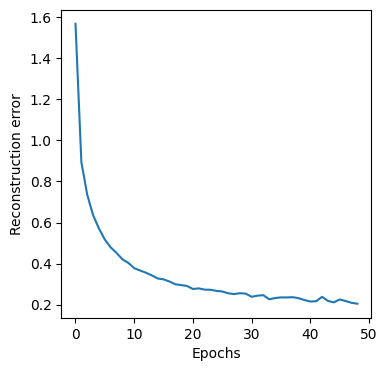

In [29]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure(figsize = (4, 4))
plt.plot(train_loss_avg[:-1])
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.savefig('loss.png')

Evaluate on the Test Set
-------------------------

In [7]:
# set to evaluation mode
autoencoder.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:
    
    # gradient calculation is disabled for inference
    with torch.no_grad():

        image_batch = image_batch.to(device).reshape(image_batch.shape[0],-1)

        # autoencoder reconstruction
        image_batch_recon = autoencoder(image_batch)

        # reconstruction error
        loss = F.mse_loss(image_batch_recon, image_batch)

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 0.148530


Visualize Reconstructions
--------------------------

Original images


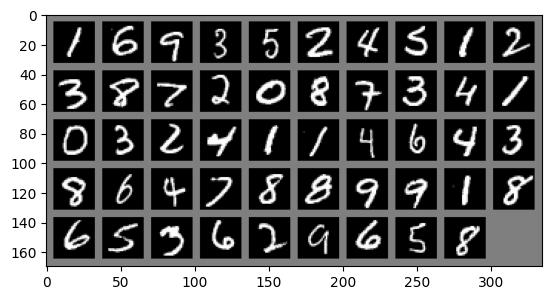

Autoencoder reconstruction:
torch.Size([128, 1, 28, 28])


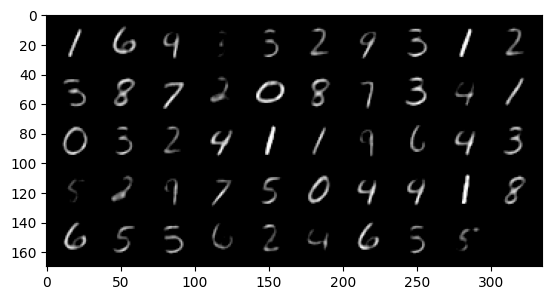

In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

autoencoder.eval()

# Note that when we preprocess the data by converting them to 
# the range of [0, 1] and then normalize and center them around 0. 
# After normalization, x was in the range of [-1, 1]. 
# to_img function can convert the x back to its original range of [0, 1].
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy() # convert torch.tensor to numpy.array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# This function takes an image to reconstruct as an input
# and the name of the model with which the reconstructions
# are performed
def visualise_output(images, model):

    with torch.no_grad():

        images = images.to(device)
        images = model(images.reshape(images.shape[0],-1))
        images = images.reshape(images.shape[0],1,28,28).cpu()
        images = images.clamp(0,1)
        print(images.shape)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = next(iter(test_dataloader))


# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the autoencoder
print('Autoencoder reconstruction:')
visualise_output(images, autoencoder)

Visualize low-dimensional latent feature
-------------------------
In this section, we use our trained encoder to encode each input data into a low-dimensional 2D feature vector. Then we visualize the 2D feature in a plane along with its label. Different colors correspond different numbers.

In [10]:
Z=[]  # latent features
labels=[] 
for image_batch, label in test_dataloader:    
    with torch.no_grad():

        image_batch = image_batch.to(device).reshape(image_batch.shape[0],-1)

        # autoencoder reconstruction
        Z.append(autoencoder.encode(image_batch).data.cpu().numpy())
        labels.append(label.data.cpu().numpy())

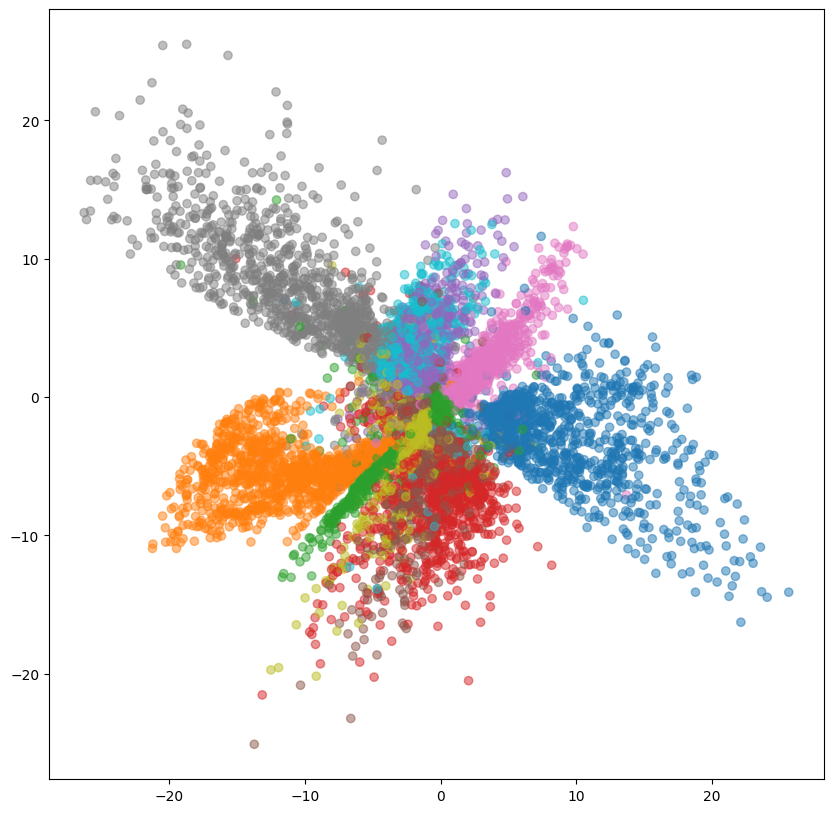

In [11]:
fig=plt.figure(figsize=(10,10))
plt.scatter(np.concatenate(Z)[:,0],np.concatenate(Z)[:,1],alpha=.5,
            c=np.concatenate(labels),cmap='tab10')

Visualize images from latent features
-------------------------
In the previous section, we visualize all the low-dimensional features in 2D plane. Here, we first define a region in latent space, e.g., a squared region with x and y ranges from -15 to 10. Then, we sample latent features within this region and visualize the corresponding reconstructed images by using decoder.

In [12]:
L=15
X,Y=torch.meshgrid(torch.linspace(-15,10,L),torch.linspace(-15,10,L))
zgrid=torch.stack([X.reshape(-1),Y.reshape(-1)],1)
print(zgrid.shape)

torch.Size([225, 2])


/Users/yuwang/recsys/lib/python3.9/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


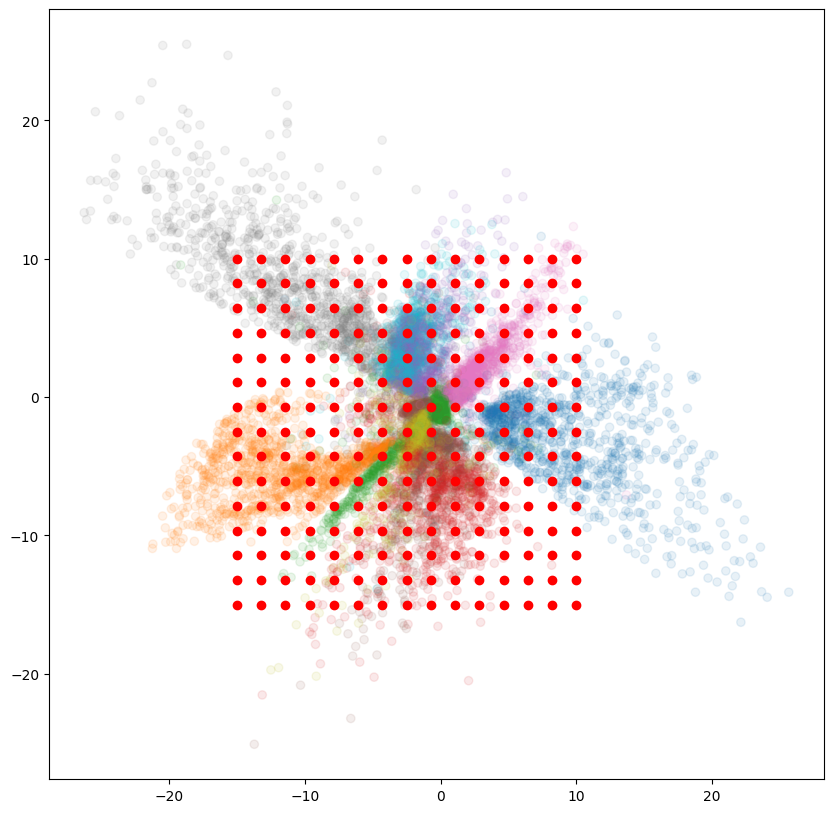

In [13]:
fig=plt.figure(figsize=(10,10))
plt.scatter(np.concatenate(Z)[:,0],np.concatenate(Z)[:,1],alpha=.1,
            c=np.concatenate(labels),cmap='tab10')
plt.scatter(zgrid[:,0],zgrid[:,1],c='r')

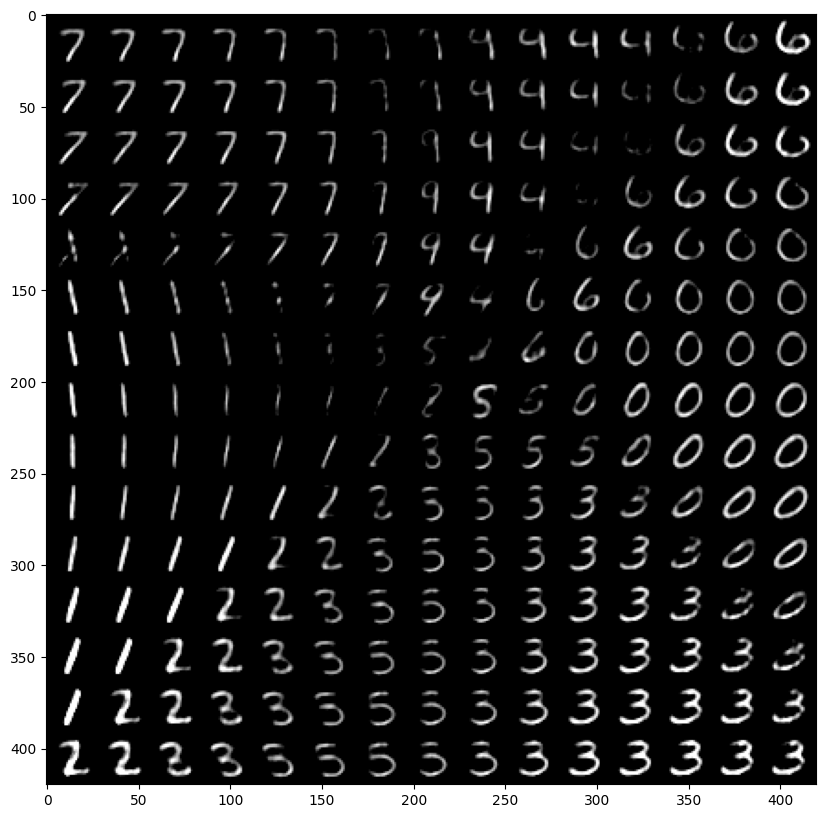

In [14]:
image=autoencoder.decode(zgrid.to(device)).reshape(L**2,28,28).data.clip(0,1).cpu().numpy()
img=np.zeros((L*28,L*28))
count=0
for i in np.arange(L-1,-1,-1):
  for j in np.arange(L-1,-1,-1):    
    img[j*28:(j+1)*28,i*28:(i+1)*28]=image[count,:,::-1]
    count+=1
fig=plt.figure(figsize=(10,10))
img=img[:,::-1]
plt.imshow(img,cmap='gray')

In [15]:
class MLP_Discriminant_AE(nn.Module):
  def __init__(self,architecture=[784,128,64,2],nclasses=10,activation='LeakyReLU'):
        super(MLP_Discriminant_AE, self).__init__()
        self.architecture=architecture
        if activation=='LeakyReLU':
            self.activation=nn.LeakyReLU()
        elif activation=='ReLU':
            self.activation=nn.ReLU()
        elif activation=='Sigmoid':
            self.activation=nn.Sigmoid()
        else:
            print('Activation not defined, reverting to default!')
            self.activation=nn.LeakyReLU()
        # Defining $\phi$
        arch=[]
        for i in range(1,len(architecture)):
            arch.append(nn.Linear(architecture[i-1],architecture[i]))
            if i!=len(architecture)-1:
                arch.append(self.activation)
        self.encoder=nn.Sequential(*arch)
        # Defining $\psi$
        arch=[]
        for i in range(len(architecture)-1,0,-1):
            arch.append(nn.Linear(architecture[i],architecture[i-1]))
            if i!=1:
                arch.append(self.activation)
        self.decoder=nn.Sequential(*arch)
        self.classifier=nn.Linear(architecture[-1],nclasses)
        self.nclasses=nclasses

  def encode(self,f):
        assert f.shape[1]==self.architecture[0]
        return self.encoder(f)

  def decode(self,fhat):
        assert fhat.shape[1]==self.architecture[-1]
        return self.decoder(fhat)

  def forward(self,x):
    z=self.encode(x)
    return self.decode(z),self.classifier(z)
    
model = MLP_Discriminant_AE()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
model = model.to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 218544


In [16]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
autoencoder.train()
train_loss_avg = []
reconCriterion=nn.MSELoss()  # MSE loss is used for image reconstruction
classificationCriterion=nn.CrossEntropyLoss() # CEloss is used for classification
print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, y in train_dataloader:
        
        image_batch = image_batch.to(device).reshape(image_batch.shape[0],-1)
        
        # autoencoder reconstruction
        image_batch_recon, ypred = model(image_batch)
        
        # reconstruction error
        loss = (reconCriterion(image_batch_recon, image_batch)+
                classificationCriterion(ypred,y))
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 50] average reconstruction error: 1.567750
Epoch [2 / 50] average reconstruction error: 0.894052
Epoch [3 / 50] average reconstruction error: 0.735229
Epoch [4 / 50] average reconstruction error: 0.635430
Epoch [5 / 50] average reconstruction error: 0.570618
Epoch [6 / 50] average reconstruction error: 0.517012
Epoch [7 / 50] average reconstruction error: 0.478771
Epoch [8 / 50] average reconstruction error: 0.451770
Epoch [9 / 50] average reconstruction error: 0.420754
Epoch [10 / 50] average reconstruction error: 0.403587
Epoch [11 / 50] average reconstruction error: 0.377795
Epoch [12 / 50] average reconstruction error: 0.366536
Epoch [13 / 50] average reconstruction error: 0.355639
Epoch [14 / 50] average reconstruction error: 0.342801
Epoch [15 / 50] average reconstruction error: 0.327627
Epoch [16 / 50] average reconstruction error: 0.323371
Epoch [17 / 50] average reconstruction error: 0.312858
Epoch [18 / 50] average reconstruction error: 0.299553
Epoch 

In [17]:
Z=[]
labels=[]
for image_batch, label in test_dataloader:    
    with torch.no_grad():

        image_batch = image_batch.to(device).reshape(image_batch.shape[0],-1)

        # autoencoder reconstruction
        Z.append(model.encode(image_batch).data.cpu().numpy())
        labels.append(label.data.cpu().numpy())

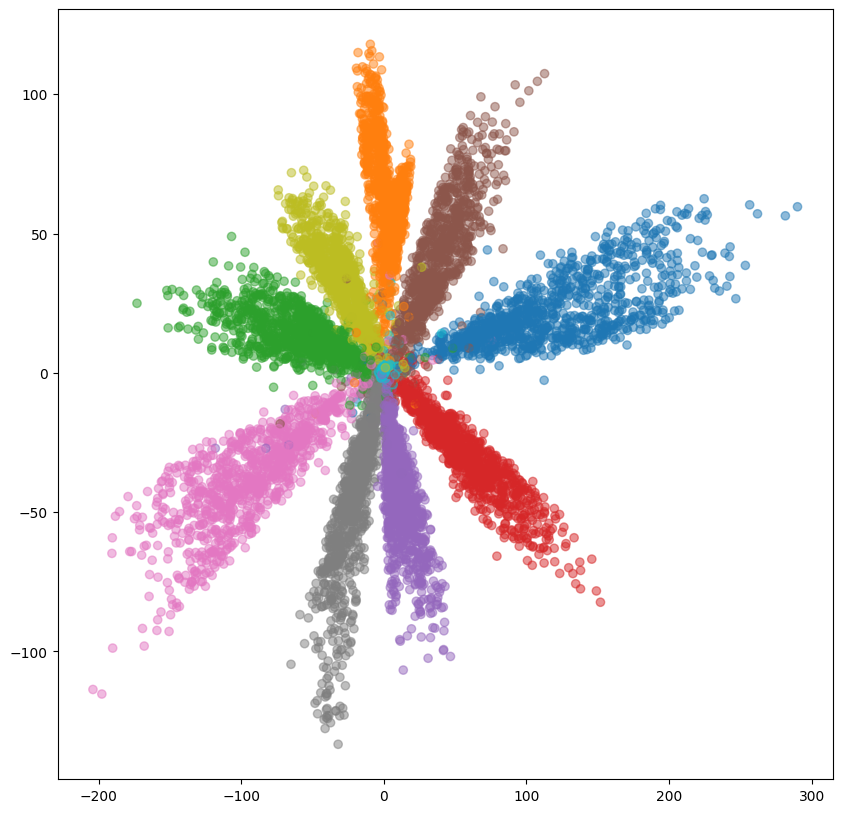

In [18]:
fig=plt.figure(figsize=(10,10))
plt.scatter(np.concatenate(Z)[:,0],np.concatenate(Z)[:,1],alpha=.5,
            c=np.concatenate(labels),cmap='tab10')

In [19]:
L=15
X,Y=torch.meshgrid(torch.linspace(-100,200,L),torch.linspace(-100,100,L))
zgrid=torch.stack([X.reshape(-1),Y.reshape(-1)],1)
print(zgrid.shape)

torch.Size([225, 2])


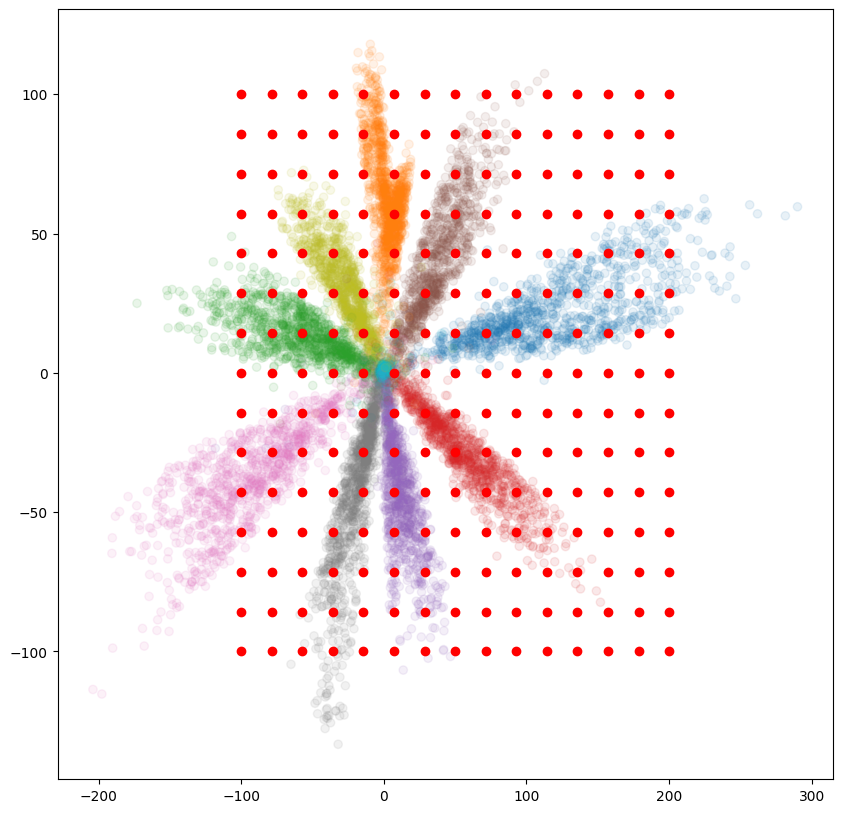

In [20]:
fig=plt.figure(figsize=(10,10))
plt.scatter(np.concatenate(Z)[:,0],np.concatenate(Z)[:,1],alpha=.1,
            c=np.concatenate(labels),cmap='tab10')
plt.scatter(zgrid[:,0],zgrid[:,1],c='r')

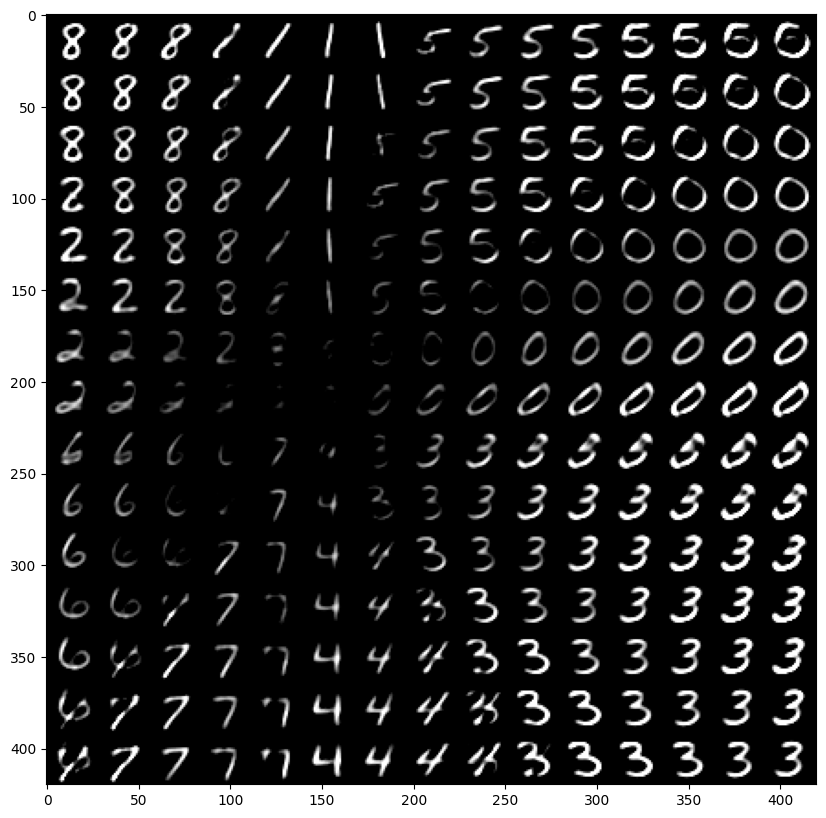

In [21]:
image=model.decode(zgrid.to(device)).reshape(L**2,28,28).data.clip(0,1).cpu().numpy()
img=np.zeros((L*28,L*28))
count=0
for i in np.arange(L-1,-1,-1):
  for j in np.arange(L-1,-1,-1):    
    img[j*28:(j+1)*28,i*28:(i+1)*28]=image[count,:,::-1]
    count+=1
fig=plt.figure(figsize=(10,10))
img=img[:,::-1]
plt.imshow(img,cmap='gray')

Original images


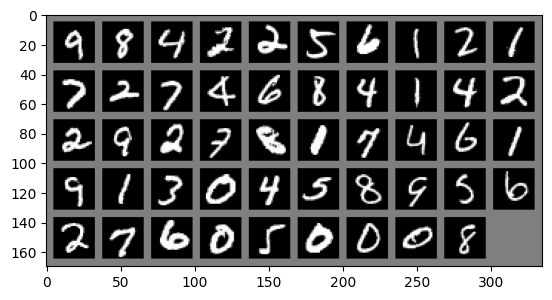

Autoencoder reconstruction:
torch.Size([128, 1, 28, 28])


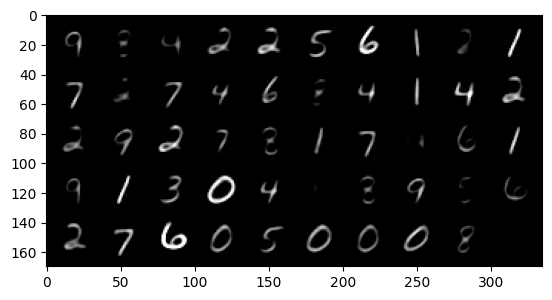

In [32]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

autoencoder.eval()

# Note that when we preprocess the data by converting them to 
# the range of [0, 1] and then normalize and center them around 0. 
# After normalization, x was in the range of [-1, 1]. 
# to_img function can convert the x back to its original range of [0, 1].
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy() # convert torch.tensor to numpy.array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# This function takes an image to reconstruct as an input
# and the name of the model with which the reconstructions
# are performed
def visualise_output(images, model):

    with torch.no_grad():

        images = images.to(device)
        images = model(images.reshape(images.shape[0],-1))[0]
        images = images.reshape(images.shape[0],1,28,28).cpu()
        images = images.clamp(0,1)
        print(images.shape)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = next(iter(test_dataloader))


# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the autoencoder
print('Autoencoder reconstruction:')
visualise_output(images, model)

Variational Autoencoders
======

In [12]:
# 1. Setup: Imports and Data Loading
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.manifold import TSNE  # for latent visualization if needed
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 128
LATENT_DIM = 2  # set to 2 for scatter plot or 20 for t-SNE visualization
learning_rate = 1e-3
num_epochs = 10

# MNIST dataset
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [13]:
# 2. Define VAE Model
class VAE(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM):
        super(VAE, self).__init__()
        # Encoder layers (784 -> 400 -> latent)
        self.fc1 = nn.Linear(784, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)
        # Decoder layers (latent -> 400 -> 784)
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)
    def encode(self, x):
        x = x.view(x.size(0), -1)  # flatten input
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    def decode(self, z):
        h = torch.relu(self.fc3(z))
        out = torch.sigmoid(self.fc4(h))
        return out
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

model = VAE(latent_dim=LATENT_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [14]:
# 3. Training loop
history_total_loss = []
history_recon_loss = []
history_kl_loss = []
for epoch in range(1, num_epochs + 1):
    model.train()
    train_recon_sum = 0.0
    train_kl_sum = 0.0
    for images, _ in train_loader:
        images = images.to(device)
        recon, mu, logvar = model(images)
        # Compute reconstruction and KL divergence losses
        recon_loss = F.binary_cross_entropy(recon, images.view(-1, 784), reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        # Backpropagation
        loss = (recon_loss + kl_loss) / images.size(0)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_recon_sum += recon_loss.item()
        train_kl_sum += kl_loss.item()
    # Average losses for the epoch
    train_recon_avg = train_recon_sum / len(train_dataset)
    train_kl_avg = train_kl_sum / len(train_dataset)
    train_total_avg = train_recon_avg + train_kl_avg
    history_recon_loss.append(train_recon_avg)
    history_kl_loss.append(train_kl_avg)
    history_total_loss.append(train_total_avg)
    print(f"Epoch {epoch}/{num_epochs}, Total Loss: {train_total_avg:.4f}, Recon Loss: {train_recon_avg:.4f}, KL Loss: {train_kl_avg:.4f}")


Epoch 1/10, Total Loss: 189.8634, Recon Loss: 184.3253, KL Loss: 5.5382
Epoch 2/10, Total Loss: 167.3367, Recon Loss: 162.0123, KL Loss: 5.3245
Epoch 3/10, Total Loss: 163.7139, Recon Loss: 158.2960, KL Loss: 5.4179
Epoch 4/10, Total Loss: 161.4394, Recon Loss: 155.9442, KL Loss: 5.4952
Epoch 5/10, Total Loss: 159.7249, Recon Loss: 154.1437, KL Loss: 5.5812
Epoch 6/10, Total Loss: 158.3941, Recon Loss: 152.7617, KL Loss: 5.6325
Epoch 7/10, Total Loss: 157.3329, Recon Loss: 151.6448, KL Loss: 5.6881
Epoch 8/10, Total Loss: 156.3459, Recon Loss: 150.6131, KL Loss: 5.7327
Epoch 9/10, Total Loss: 155.5519, Recon Loss: 149.7827, KL Loss: 5.7692
Epoch 10/10, Total Loss: 154.8613, Recon Loss: 149.0604, KL Loss: 5.8009


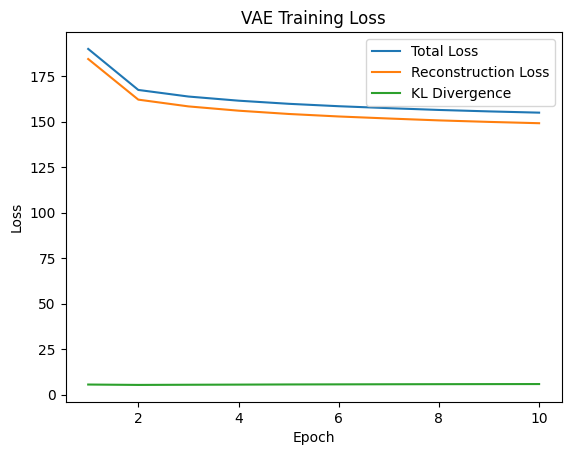

In [15]:
# 4. Plot training loss curves
epochs = range(1, num_epochs + 1)
plt.figure()
plt.plot(epochs, history_total_loss, label='Total Loss')
plt.plot(epochs, history_recon_loss, label='Reconstruction Loss')
plt.plot(epochs, history_kl_loss, label='KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('VAE Training Loss')
plt.show()


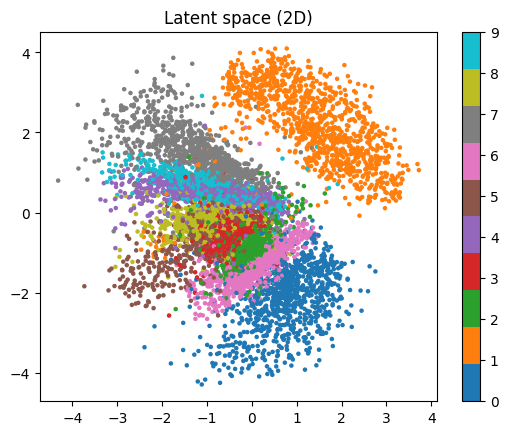

In [16]:
# 5. Visualize learned 2D latent space
model.eval()
all_mu = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        mu, logvar = model.encode(images)
        all_mu.append(mu.cpu())
        all_labels.append(labels)
all_mu = torch.cat(all_mu).numpy()
all_labels = torch.cat(all_labels).numpy()
if LATENT_DIM > 2:
    # Use t-SNE to reduce latent space to 2D for visualization
    z_2d = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(all_mu)
    plt.figure()
    plt.scatter(z_2d[:, 0], z_2d[:, 1], c=all_labels, cmap='tab10', s=5)
    plt.colorbar()
    plt.title('t-SNE of latent space')
    plt.show()
elif LATENT_DIM == 2:
    plt.figure()
    plt.scatter(all_mu[:, 0], all_mu[:, 1], c=all_labels, cmap='tab10', s=5)
    plt.colorbar()
    plt.title('Latent space (2D)')
    plt.show()


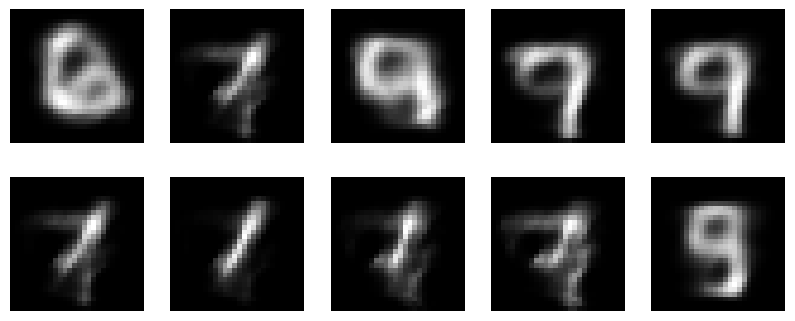

In [17]:
# 7. Generate new digit samples from random latent vectors
model.eval()
with torch.no_grad():
    z = torch.randn(10, LATENT_DIM).to(device)
    samples = model.decode(z).view(-1, 1, 28, 28).cpu()
# Plot generated images
fig, axes = plt.subplots(2, 5, figsize=(5*2, 2*2))
axes = axes.flatten()
for i in range(10):
    axes[i].imshow(samples[i].squeeze(), cmap='gray')
    axes[i].axis('off')
plt.show()


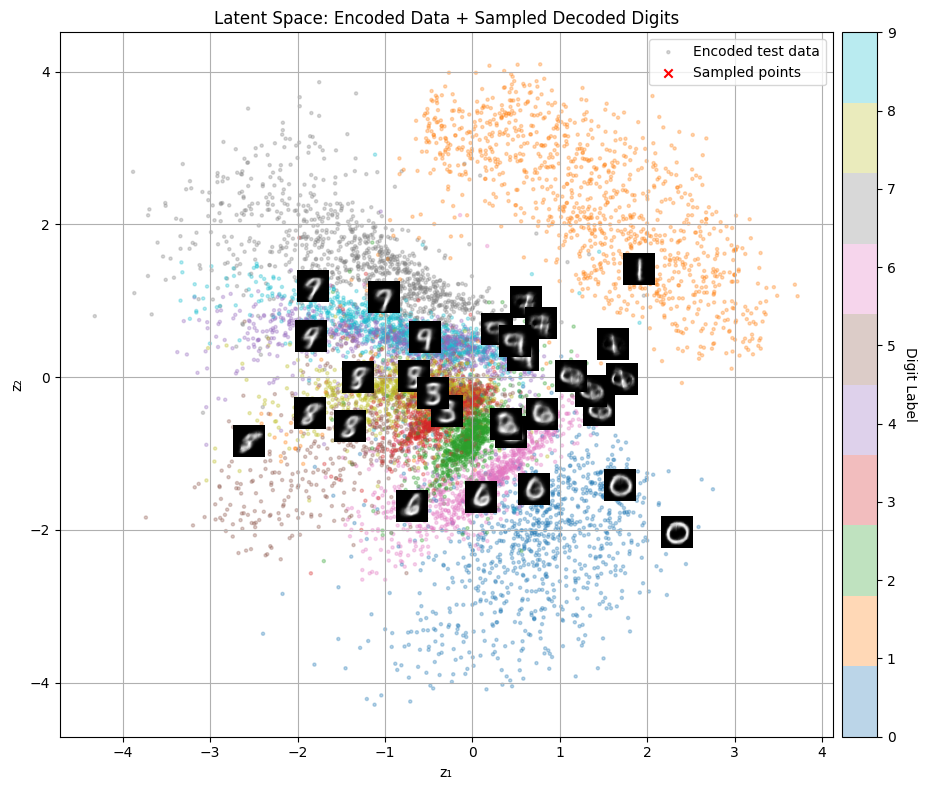

In [18]:
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Step 1. Encode real test images (mu) and collect their labels
model.eval()
all_mu = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        mu, logvar = model.encode(images)
        all_mu.append(mu.cpu())
        all_labels.append(labels)
all_mu = torch.cat(all_mu).numpy()
all_labels = torch.cat(all_labels).numpy()

# Step 2. Randomly sample latent points and decode them into images
with torch.no_grad():
    z_samples = torch.randn(30, LATENT_DIM).to(device)  # 30 random points
    decoded_samples = model.decode(z_samples).cpu().view(-1, 28, 28)
    z_samples = z_samples.cpu().numpy()

# Step 3. Create a single unified plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the encoded real data (mu) as background scatter
scatter = ax.scatter(all_mu[:, 0], all_mu[:, 1], c=all_labels, cmap='tab10', alpha=0.3, s=5, label='Encoded test data')

# Add colorbar with digit labels (0–9)
cbar = plt.colorbar(scatter, ax=ax, pad=0.01)
cbar.set_ticks(range(10))
cbar.set_ticklabels([str(i) for i in range(10)])
cbar.set_label('Digit Label', rotation=270, labelpad=15)

# Mark sampled points with red 'X'
ax.scatter(z_samples[:, 0], z_samples[:, 1], color='red', marker='x', label='Sampled points')

# Attach decoded images at sampled latent points
def imscatter(x, y, images, ax=None, zoom=0.6):
    ax = ax or plt.gca()
    for xi, yi, img in zip(x, y, images):
        img = img.numpy()
        im = OffsetImage(img, cmap='gray', zoom=zoom)
        ab = AnnotationBbox(im, (xi, yi), frameon=False)
        ax.add_artist(ab)

imscatter(z_samples[:, 0], z_samples[:, 1], decoded_samples, ax=ax, zoom=0.8)

# Final touch-ups
ax.legend(loc='upper right')
ax.set_title('Latent Space: Encoded Data + Sampled Decoded Digits')
ax.set_xlabel('z₁')
ax.set_ylabel('z₂')
ax.grid(True)
plt.tight_layout()
plt.show()


## Sliced WE AE

In [1]:
# Imports and Data Loading
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Hyperparameters
latent_dim = 2
hidden_dim = 400
batch_size = 128
learning_rate = 1e-3
epochs = 20
lambda_reg = 10
num_projections = 50

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MNIST dataset (images and labels)
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [2]:
# Define Encoder and Decoder neural network architectures
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, latent_dim)
    def forward(self, x):
        x = x.view(x.size(0), -1)   # flatten 28x28 images
        x = F.relu(self.fc1(x))
        z = self.fc2(x)
        return z

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 28*28)
    def forward(self, z):
        z = F.relu(self.fc1(z))
        x_recon = torch.sigmoid(self.fc2(z))  # output in [0,1] for BCE
        return x_recon

# Initialize models and optimizer
encoder = Encoder().to(device)
decoder = Decoder().to(device)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)


In [3]:
# Sliced Wasserstein distance (SWD) function
def sliced_wasserstein_distance(z_real, z_prior, n_projections=50):
    # 1. Sample random projection directions from the unit sphere
    d = z_real.shape[1]
    directions = torch.randn(d, n_projections, device=z_real.device)  # random directions
    directions = directions / torch.sqrt(torch.sum(directions**2, dim=0, keepdim=True))  # normalize
    
    # 2. Project real and prior samples onto the random directions
    proj_real = z_real @ directions  # shape: [batch_size, n_projections]
    proj_prior = z_prior @ directions  # shape: [batch_size, n_projections]
    
    # 3. Sort the projections along each direction
    proj_real_sorted, _ = torch.sort(proj_real, dim=0)
    proj_prior_sorted, _ = torch.sort(proj_prior, dim=0)
    
    # 4. Compute the average L2 distance between sorted projections (1D Wasserstein distance for each projection)
    diffs = proj_real_sorted - proj_prior_sorted
    dist = torch.sqrt(torch.mean(diffs**2, dim=0))  # L2 distance for each projection
    
    # 5. Return the average distance over all projections
    return torch.mean(dist)


In [4]:
# Training loop
encoder.train()
decoder.train()
train_losses = []
recon_losses = []
sw_losses = []
for epoch in range(epochs):
    total_loss = 0.0
    total_recon = 0.0
    total_sw = 0.0
    for images, _ in train_loader:
        images = images.to(device)
        # Forward pass: encode and decode
        z = encoder(images)
        recon_images = decoder(z)
        # Compute reconstruction loss (binary cross-entropy)
        recon_loss = F.binary_cross_entropy(recon_images, images.view(images.size(0), -1), reduction='sum') / images.size(0)
        # Sample from prior (standard normal) and compute sliced Wasserstein loss
        z_prior = torch.randn_like(z)
        sw_loss = sliced_wasserstein_distance(z, z_prior, n_projections=num_projections)
        # Total loss = reconstruction + lambda * SWD
        loss = recon_loss + lambda_reg * sw_loss
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Accumulate losses for monitoring
        total_loss += loss.item() * images.size(0)
        total_recon += recon_loss.item() * images.size(0)
        total_sw += sw_loss.item() * images.size(0)
    # Average losses for the epoch
    avg_loss = total_loss / len(train_loader.dataset)
    avg_recon = total_recon / len(train_loader.dataset)
    avg_sw = total_sw / len(train_loader.dataset)
    train_losses.append(avg_loss)
    recon_losses.append(avg_recon)
    sw_losses.append(avg_sw)
    print(f"Epoch [{epoch+1}/{epochs}] - Recon Loss: {avg_recon:.4f}, SW Loss: {avg_sw:.4f}, Total Loss: {avg_loss:.4f}")


Epoch [1/20] - Recon Loss: 177.9900, SW Loss: 0.5838, Total Loss: 183.8280
Epoch [2/20] - Recon Loss: 159.7512, SW Loss: 0.2296, Total Loss: 162.0468
Epoch [3/20] - Recon Loss: 156.2663, SW Loss: 0.2333, Total Loss: 158.5993
Epoch [4/20] - Recon Loss: 153.8436, SW Loss: 0.2257, Total Loss: 156.1005
Epoch [5/20] - Recon Loss: 152.0215, SW Loss: 0.2291, Total Loss: 154.3126
Epoch [6/20] - Recon Loss: 150.4848, SW Loss: 0.2250, Total Loss: 152.7348
Epoch [7/20] - Recon Loss: 149.1125, SW Loss: 0.2237, Total Loss: 151.3491
Epoch [8/20] - Recon Loss: 147.9704, SW Loss: 0.2206, Total Loss: 150.1768
Epoch [9/20] - Recon Loss: 147.0083, SW Loss: 0.2238, Total Loss: 149.2464
Epoch [10/20] - Recon Loss: 146.1215, SW Loss: 0.2200, Total Loss: 148.3212
Epoch [11/20] - Recon Loss: 145.4012, SW Loss: 0.2198, Total Loss: 147.5994
Epoch [12/20] - Recon Loss: 144.7527, SW Loss: 0.2194, Total Loss: 146.9464
Epoch [13/20] - Recon Loss: 144.2071, SW Loss: 0.2183, Total Loss: 146.3897
Epoch [14/20] - Recon

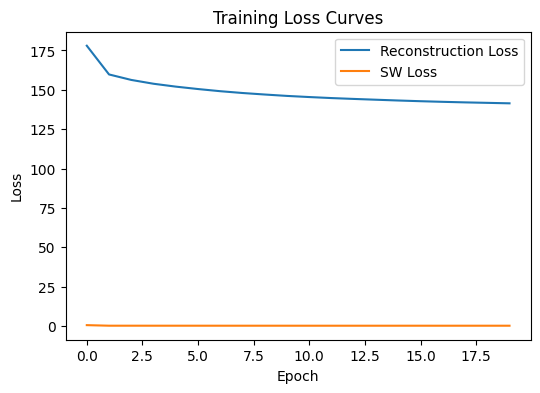

In [5]:
# Plot training loss curves for reconstruction and SWD losses
plt.figure(figsize=(6,4))
plt.plot(recon_losses, label='Reconstruction Loss')
plt.plot(sw_losses, label='SW Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Curves')
plt.show()


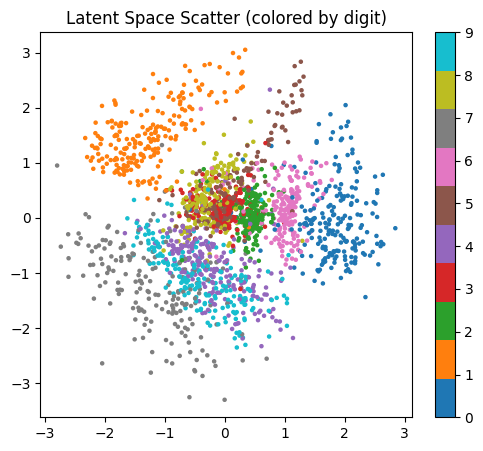

In [6]:
# Visualize the 2D latent space with a scatter plot
encoder.eval()
decoder.eval()
all_z = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        z = encoder(images)
        all_z.append(z.cpu())
        all_labels.append(labels)
all_z = torch.cat(all_z)
all_labels = torch.cat(all_labels)
# Use a subset of points for clarity
subset = 2000
if all_z.size(0) > subset:
    idx = torch.randperm(all_z.size(0))[:subset]
    z_plot = all_z[idx].numpy()
    labels_plot = all_labels[idx].numpy()
else:
    z_plot = all_z.numpy()
    labels_plot = all_labels.numpy()
plt.figure(figsize=(6,5))
plt.scatter(z_plot[:,0], z_plot[:,1], c=labels_plot, cmap='tab10', s=5)
cbar = plt.colorbar()
cbar.set_ticks(range(10))
plt.title('Latent Space Scatter (colored by digit)')
plt.show()


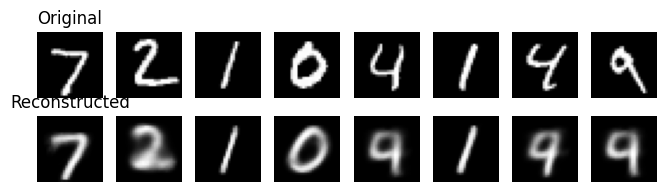

In [7]:
# Display original vs reconstructed images
# Get a batch of test images and reconstruct them
examples = next(iter(test_loader))
test_imgs, _ = examples
test_imgs = test_imgs.to(device)
with torch.no_grad():
    recon_imgs = decoder(encoder(test_imgs))
# Take first 8 images for visualization
orig_imgs = test_imgs[:8].cpu()
recon_imgs = recon_imgs[:8].cpu()
plt.figure(figsize=(8,2))
for i in range(8):
    # original image
    plt.subplot(2, 8, i+1)
    plt.imshow(orig_imgs[i].view(28,28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title('Original')
    # reconstructed image
    plt.subplot(2, 8, 8 + i + 1)
    plt.imshow(recon_imgs[i].view(28,28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title('Reconstructed')
plt.show()


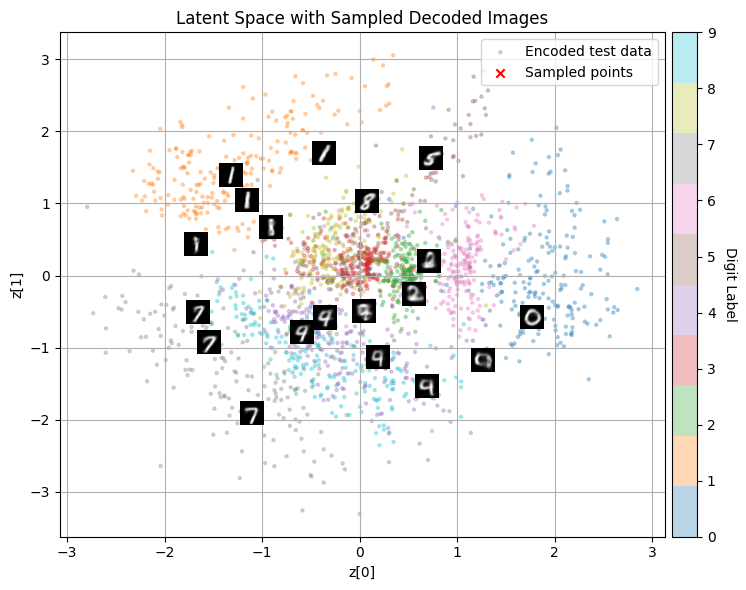

In [10]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def imscatter(x, y, images, ax=None, zoom=0.5):
    ax = ax or plt.gca()
    for xi, yi, img in zip(x, y, images):
        img = img.view(28, 28).numpy()
        im = OffsetImage(img, cmap='gray', zoom=zoom)
        ab = AnnotationBbox(im, (xi, yi), frameon=False)
        ax.add_artist(ab)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter the encoded test data
scatter = ax.scatter(z_plot[:, 0], z_plot[:, 1], c=labels_plot, cmap='tab10', alpha=0.3, s=5, label='Encoded test data')

# Add colorbar with digit labels (0–9)
cbar = plt.colorbar(scatter, ax=ax, pad=0.01)
cbar.set_ticks(range(10))
cbar.set_ticklabels([str(i) for i in range(10)])
cbar.set_label('Digit Label', rotation=270, labelpad=15)

# Sample and decode from prior
num_samples = 20
z_samples = torch.randn(num_samples, latent_dim).to(device)
with torch.no_grad():
    decoded_samples = decoder(z_samples).cpu()
z_samples_np = z_samples.cpu().numpy()

# Mark sampled points with red X
ax.scatter(z_samples_np[:, 0], z_samples_np[:, 1], color='red', marker='x', label='Sampled points')

# Overlay decoded images at sampled locations
imscatter(z_samples_np[:, 0], z_samples_np[:, 1], decoded_samples, ax=ax, zoom=0.6)

# Final touches
ax.legend(loc='upper right')
ax.set_title('Latent Space with Sampled Decoded Images')
ax.set_xlabel('z[0]')
ax.set_ylabel('z[1]')
ax.grid(True)
plt.tight_layout()
plt.show()
